In [67]:
import sys
sys.path.append(r'C:/Users/ryoo/AppData/Local/gsas2main/GSAS-II')

import GSASII.GSASIIpath as GSASIIpath
GSASIIpath.binaryPath = r'C:/Users/ryoo/AppData/Local/gsas2main/GSAS-II/GSASII-bin/win_64_p3.13_n2.2'
GSASIIpath.SetBinaryPath(True)

import GSASII.GSASIIscriptable as G2sc
from GSASII import GSASIIspc as G2spc
from GSASII import GSASIIlattice as G2lat

import matplotlib.pyplot as plt 
from matplotlib.collections import LineCollection
from matplotlib.legend_handler import HandlerLineCollection
import numpy as np

In [68]:
"""
Create Pawley reflection from unit cell parameters from phase cif 
"""

def pawley_create(gpx, phase_name, dmin=None, dmax=None, neg_wt=0.0):
    ph  = gpx.phase(phase_name)
    gen = ph.data['General']
    SG  = gen['SGData']

    # d-range
    dmin = float(dmin if dmin is not None else gen.get('Pawley dmin', 1.0))
    dmax = float(dmax if dmax is not None else gen.get('Pawley dmax', 100.0))
    gen['doPawley']      = True
    gen['Pawley dmin']   = dmin
    gen['Pawley dmax']   = dmax
    gen['Pawley neg wt'] = float(neg_wt)

    # reciprocal matrix → hkl
    A6 = np.array(G2lat.cell2A(gen['Cell'][1:7]), float)  
    HKL_mult_list = G2lat.GenHLaue(dmin, SG, A6)
    rd2 = getattr(G2lat, 'calc_rDsq', getattr(G2lat, 'Calc_rDsq', None))

    pawley_refs = []
    for h,k,l,mul in HKL_mult_list:
        d = 1.0/np.sqrt(rd2([h,k,l], A6))
        if dmin <= d <= dmax:
            pawley_refs.append([float(h), float(k), float(l),
                                int(mul), float(d), False, 0.0, 1.0])

    pawley_refs.sort(key=lambda x: x[4], reverse=True)
    ph.data['Pawley ref'] = pawley_refs

    for hname, _ in ph.data.get('Histograms', {}).items():
        h = gpx.histogram(hname)
        h.data['Use'] = True
        h.data['LeBail'] = False
    return len(pawley_refs)

def _apply_refine_flags(ph, predicate, default=False):
    """predicate(h,k,l,mul,d,idx) → True 인 반사만 refine 체크"""
    refs = ph.data.get('Pawley ref', [])
    if not refs:
        print("No Pawley reflections found.")
        return 0
    n = 0
    for i, r in enumerate(refs):
        h, k, l, mul, d = int(r[0]), int(r[1]), int(r[2]), int(r[3]), float(r[4])
        flag = bool(predicate(h, k, l, mul, d, i))
        r[5] = flag if flag is not None else default
        n += int(r[5] is True)
    return n

def pawley_select_by_indices(gpx, phase_name, indices, on=True):
    idxset = set(indices)
    ph = gpx.phase(phase_name)
    _apply_refine_flags(ph, lambda h,k,l,mul,d,i: (i in idxset) == True and on, default=False)
    gpx.save()


def pawley_select_by_limit(gpx, phase_name, hist_index=0, wavelength=1.5406):
    """
    histogram의 Limits 범위 내에 있는 Pawley reflection만 refine하도록 설정
    
    Parameters:
    -----------
    gpx : G2Project
        GSAS-II project object
    phase_name : str
        Phase name
    hist_index : int
        Histogram index (default: 0)
    wavelength : float
        X-ray wavelength in Angstrom (default: 1.5406 for Cu K-alpha)
    
    Returns:
    --------
    int : Number of selected reflections
    """
    import numpy as np
    
    ph = gpx.phase(phase_name)
    hist = gpx.histogram(hist_index)
    
    # histogram limits
    limits = hist.data['Limits'][1]  # [min_2theta, max_2theta]
    min_2theta, max_2theta = limits[0], limits[1]
    
    # Pawley reflections 
    refs = ph.data.get('Pawley ref', [])
    if not refs:
        print("No Pawley reflections found.")
        return 0
    
    # d-spacing to 2theta
    def d_to_2theta(d, lam):
        theta = np.arcsin(lam / (2 * d))
        return 2 * np.degrees(theta)
    
    # using reflections in the limits range
    n_selected = 0
    for i, r in enumerate(refs):
        d = float(r[4])  # d-spacing in Angstrom
        two_theta = d_to_2theta(d, wavelength)
        
        # limits 범위 내에 있으면 refine flag를 True로
        if min_2theta <= two_theta <= max_2theta:
            r[5] = True
            n_selected += 1
        else:
            r[5] = False
    
    gpx.save()
    print(f"Selected {n_selected} reflections within 2θ range [{min_2theta:.2f}, {max_2theta:.2f}]")
    print(f"Using wavelength: {wavelength} Å")
    return n_selected

In [69]:
def load_background_from_file(gpx, hist_index, background_file):
    """
    GSAS-II background parameter file (.pwdrbck)을 로드해서 histogram에 적용
    
    Parameters:
    -----------
    gpx : G2Project
        GSAS-II project object
    hist_index : int
        Histogram index
    background_file : str
        Path to .pwdrbck file
    """
    import ast
    
    hist = gpx.histogram(hist_index)
    
    with open(background_file, 'r') as f:
        lines = f.readlines()
    
    # Read background parameters 
    # ['chebyschev-1', True, 5, 13744.9516, -11410.0, 619.7199, 602.0776, 344.6025]
    bkg_line = lines[0].strip()
    if bkg_line.startswith('#'):
        bkg_line = lines[1].strip()
    
    bkg_params = ast.literal_eval(bkg_line)
    
    bkg_type = bkg_params[0]  # 'chebyschev-1'
    refine = bkg_params[1]     # True
    n_coeffs = bkg_params[2]   # 5
    coeffs = bkg_params[3:]    # [13744.9516, -11410.0, 619.7199, 602.0776, 344.6025]
    
    # background setting
    hist.set_refinements({
        "Background": {
            'type': bkg_type,
            'refine': refine,
            'no. coeffs': n_coeffs,
            'coeffs': coeffs
        }
    })
    
    gpx.save()
    print(f"Loaded background from {background_file}")
    print(f"Type: {bkg_type}, Coeffs: {n_coeffs}, Refine: {refine}")
    
    return bkg_params

In [266]:
"""
Visualize refinements
"""

def _get_bragg_positions(gpx, hist, phase_name):
    limits = hist.data['Limits'][1]
    hist_name = hist.name
    positions = []

    refl_lists = hist.data.get('Reflection Lists', {})
    if phase_name in refl_lists:
        for refl in refl_lists[phase_name].get('RefList', []):
            try:
                pos = float(refl[5])           # 2θ
                if limits[0] <= pos <= limits[1]:
                    positions.append(pos)
            except Exception:
                pass

    if not positions and phase_name in gpx.data.get('Phases', {}):
        ph = gpx.phase(phase_name)
        ph_hist = ph.data.get('Histograms', {}).get(hist_name, {})
        ref_list = ph_hist.get('RefList', ph_hist.get('Reflection List', []))
        for refl in ref_list:
            try:
                pos = float(refl[5])
                if limits[0] <= pos <= limits[1]:
                    positions.append(pos)
            except Exception:
                pass

    return sorted(positions)

def _set_robust_ylim(ax, x, ys, limits, pct=(0.5, 99.5), pad=0.05, floor=0):
    mask = (x >= limits[0]) & (x <= limits[1])
    vals = np.concatenate([np.asarray(y)[mask].ravel() for y in ys])
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        ax.relim(); ax.autoscale(axis='y'); return
    lo = np.nanpercentile(vals, pct[0])
    hi = np.nanpercentile(vals, pct[1])
    if floor is not None:
        lo = max(lo, floor)  
    if hi <= lo:  
        lo, hi = np.nanmin(vals), np.nanmax(vals)
    span = max(hi - lo, 1e-9)
    ax.set_ylim(lo - pad*span, hi + pad*span)

def plot_refinement_result_subplots(gpx, hist_index=0, phase_name=None, figsize=(12, 12)):
    hist = gpx.histogram(hist_index)
    hist_name = hist.name

    # 일관된 키 사용
    x      = hist.getdata('x')
    y_obs  = hist.getdata('yobs')
    y_calc = hist.getdata('ycalc')
    y_bkg  = hist.getdata('background')
    y_diff = hist.getdata('residual')

    limits = hist.data['Limits'][1]

    if phase_name is None:
        phase_names = list(gpx.data.get('Phases', {}).keys())
        if phase_names:
            phase_name = phase_names[0]

    bragg_positions = []
    if phase_name:
        bragg_positions = _get_bragg_positions(gpx, hist, phase_name)
        print(f"Final bragg_positions: {bragg_positions}")

    fig, axes = plt.subplots(4, 1, figsize=figsize, sharex=True,
                             gridspec_kw={'height_ratios': [3, 1, 1, 0.5]})

    ax1 = axes[0]
    ax1.plot(x, y_obs, 'b+', markersize=4, label='obs', alpha=0.7)
    ax1.plot(x, y_calc, 'g-', linewidth=2, label='calc')
    ax1.plot(x, y_bkg, 'r-', linewidth=1.5, label='bkg')
    ax1.axvline(limits[0], color='green', linestyle='--', linewidth=2, alpha=0.8)
    ax1.axvline(limits[1], color='red',   linestyle='--', linewidth=2, alpha=0.8)
    ax1.set_ylabel('Intensity')
    ax1.set_title(hist_name)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    _set_robust_ylim(ax1, x, [y_obs, y_calc, y_bkg], limits, pct=(0.5, 99.5), pad=0.05, floor=0)
    
    ax2 = axes[1]
    ax2.plot(x, y_diff, 'c-', linewidth=1.5, label='diff')
    ax2.axhline(0, color='black', linewidth=0.5, alpha=0.5)
    ax2.axvline(limits[0], color='green', linestyle='--', linewidth=2, alpha=0.8)
    ax2.axvline(limits[1], color='red',   linestyle='--', linewidth=2, alpha=0.8)
    ax2.set_ylabel('Difference')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    ax3 = axes[2]
    ax3.plot(x, y_bkg, 'r-', linewidth=2, label='background')
    ax3.axvline(limits[0], color='green', linestyle='--', linewidth=2, alpha=0.8)
    ax3.axvline(limits[1], color='red',   linestyle='--', linewidth=2, alpha=0.8)
    ax3.set_ylabel('Background')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)

    ax4 = axes[3]
    if bragg_positions:
        lc = ax4.vlines(bragg_positions, -0.4, 0.4,
                        color='tab:blue', linewidth=2,
                        label=f'{phase_name} Bragg peaks')

        ax4.legend(loc = 'upper right', handler_map={LineCollection: HandlerLineCollection(numpoints=2)})
    else:
        ax4.text(0.5, 0.5, 'No Bragg peaks found', transform=ax4.transAxes,
                 ha='center', va='center', fontsize=10, color='gray')
    ax4.set_ylim(-0.5, 0.5)
    ax4.set_yticks([])
    ax4.axvline(limits[0], color='green', linestyle='--', linewidth=2, alpha=0.8)
    ax4.axvline(limits[1], color='red',   linestyle='--', linewidth=2, alpha=0.8)
    ax4.grid(True, alpha=0.3)
    ax4.set_xlabel('2θ')

    for ax in axes:
        ax.set_xlim(limits[0] - 0.2, limits[1] + 0.2)

    plt.tight_layout()
    plt.show()
    return fig, axes

from matplotlib.collections import LineCollection
from matplotlib.legend_handler import HandlerLineCollection
import matplotlib.cm as cm
import numpy as np

def plot_refinement_result_subplots(
    gpx,
    hist_index=0,
    phase_names=None,          # None이면 모든 phase 자동 사용
    figsize=(12, 12),
    show_bragg_on=('top','bottom')  # 'top', 'bottom', 또는 둘 다
):
    hist = gpx.histogram(hist_index)
    hist_name = hist.name

    x      = hist.getdata('x')
    y_obs  = hist.getdata('yobs')
    y_calc = hist.getdata('ycalc')
    y_bkg  = hist.getdata('background')
    y_diff = hist.getdata('residual')
    limits = hist.data['Limits'][1]

    # ---- 모든 phase 자동 선택 ----
    if phase_names is None:
        phase_names = list(gpx.data.get('Phases', {}).keys())
    elif isinstance(phase_names, str):
        phase_names = [phase_names]

    # ---- Bragg 위치 수집 ----
    phase_bragg = {}
    for pn in phase_names:
        try:
            pos = _get_bragg_positions(gpx, hist, pn)  # 사용자 정의 함수
        except Exception:
            pos = []
        # 표시 구간 내만 사용
        phase_bragg[pn] = [p for p in pos if limits[0] <= p <= limits[1]]

    # ---- 색상 매핑: tab20 순환 ----
    cmap = cm.get_cmap('tab20', max(20, len(phase_names)))
    phase_colors = {pn: cmap(i % cmap.N) for i, pn in enumerate(phase_names)}

    # ---- Figure ----
    fig, axes = plt.subplots(
        4, 1, figsize=figsize, sharex=True,
        gridspec_kw={'height_ratios': [3, 1, 1, 0.5]}
    )

    # Top: obs/calc/bkg + Bragg
    ax1 = axes[0]
    ax1.plot(x, y_obs, 'b+', markersize=4, label='obs', alpha=0.7)
    ax1.plot(x, y_calc, 'g-', linewidth=2, label='calc')
    ax1.plot(x, y_bkg, 'r-', linewidth=1.5, label='bkg')
    ax1.axvline(limits[0], color='green', linestyle='--', linewidth=2, alpha=0.8)
    ax1.axvline(limits[1], color='red',   linestyle='--', linewidth=2, alpha=0.8)
    ax1.set_ylabel('Intensity')
    ax1.set_title(hist_name)
    ax1.grid(True, alpha=0.3)
    _set_robust_ylim(ax1, x, [y_obs, y_calc, y_bkg], limits, pct=(0.5, 99.5), pad=0.05, floor=0)

    if 'top' in show_bragg_on:
        ymax = ax1.get_ylim()[1]
        y0, y1 = 0.02 * ymax, 0.12 * ymax
        for pn in phase_names:
            if not phase_bragg[pn]: 
                continue
            ax1.vlines(phase_bragg[pn], y0, y1, color=phase_colors[pn], linewidth=1.5, alpha=0.95, label=f'{pn} Bragg')
        # 중복 라벨 제거
        h, l = ax1.get_legend_handles_labels()
        uniq = dict(zip(l, h))
        ax1.legend(uniq.values(), uniq.keys(), loc='upper right', fontsize=9)

    # Diff
    ax2 = axes[1]
    ax2.plot(x, y_diff, 'c-', linewidth=1.5, label='diff')
    ax2.axhline(0, color='black', linewidth=0.5, alpha=0.5)
    ax2.axvline(limits[0], color='green', linestyle='--', linewidth=2, alpha=0.8)
    ax2.axvline(limits[1], color='red',   linestyle='--', linewidth=2, alpha=0.8)
    ax2.set_ylabel('Difference')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    # Background
    ax3 = axes[2]
    ax3.plot(x, y_bkg, 'r-', linewidth=2, label='background')
    ax3.axvline(limits[0], color='green', linestyle='--', linewidth=2, alpha=0.8)
    ax3.axvline(limits[1], color='red',   linestyle='--', linewidth=2, alpha=0.8)
    ax3.set_ylabel('Background')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)

    # Bottom: Bragg only
    ax4 = axes[3]
    drew_any = False
    if 'bottom' in show_bragg_on:
        for pn in phase_names:
            if not phase_bragg[pn]:
                continue
            ax4.vlines(phase_bragg[pn], -0.4, 0.4, color=phase_colors[pn], linewidth=2, label=f'{pn} Bragg')
            drew_any = True
        if drew_any:
            ax4.legend(loc='upper right', handler_map={LineCollection: HandlerLineCollection(numpoints=2)}, fontsize=9)
    if not drew_any:
        ax4.text(0.5, 0.5, 'No Bragg peaks found', transform=ax4.transAxes,
                 ha='center', va='center', fontsize=10, color='gray')

    ax4.set_ylim(-0.5, 0.5)
    ax4.set_yticks([])
    ax4.axvline(limits[0], color='green', linestyle='--', linewidth=2, alpha=0.8)
    ax4.axvline(limits[1], color='red',   linestyle='--', linewidth=2, alpha=0.8)
    ax4.grid(True, alpha=0.3)
    ax4.set_xlabel('2θ')

    for ax in axes:
        ax.set_xlim(limits[0] - 0.2, limits[1] + 0.2)

    plt.tight_layout()
    plt.show()
    return fig, axes


In [224]:
import numpy as np
# filename = r'C:/Users/ryoo/Desktop/LDRD/XRD/Beamline data/Baniecki_Mar 2025/HZO/HO_ZO_Graded_HT/HO_ZO_Graded_HT_0079.tif'
filename = r'C:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\Julydata\Combi_8_674V_5100us_presoak_200deg_60s_raster_sfpx63000um_scan003_processed_masked_pattern_00_1.xye'
project = r'C:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\test.gpx'
calib = r'C:/Users/ryoo/Desktop/LDRD/XRD/Beamline data/Baniecki_Mar 2025/calibration/LaB6_detz200mm_th5deg_15s_03211554_0001.tif'
# instrument = r'C:/Users/ryoo/Desktop/LDRD/Code/XRD_processing/instrument_script.instprm'
instrument_july = r'C:/Users/ryoo/Desktop/LDRD/Code/XRD_processing/instrument_July.instprm'
controls = r'C:/Users/ryoo/Desktop/LDRD/Code/XRD_processing/image_control_script.imctrl'
HfO2phase = r'C:/Users\ryoo\Desktop\LDRD\XRD\Open crystallography & Vesta\HfO2_orthorhombic_materialsproject_computed.cif'
ZrO2phase= r'C:\Users\ryoo\Desktop\LDRD\XRD\ICDD\4-ZrO2_P42nmc_Tetragonal\PDF Card - 04-005-4504.cif'
background_july = r'C:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\Background_July.pwdrbck'

project_name = "Combi_8_674V_5100us.gpx"


In [225]:
## Create GSAS-II project
gpx = G2sc.G2Project(newgpx=project_name)  

""" 
Importing image 
"""

# ## Import TIF image
# imlst = gpx.add_image(filename)

# ## Load controls that was used with LaB6 data
# imlst[0].loadControls(controls)

# ## Integrate 2D image 
# pwdrList = imlst[0].Integrate("test3")
# gpx.save()


""" 
Importing powder pattern 
"""

pwdlist = gpx.add_powder_histogram(filename, iparams = instrument_july)
gpx.save()


C:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\Julydata\Combi_8_674V_5100us_presoak_200deg_60s_raster_sfpx63000um_scan003_processed_masked_pattern_00_1.xye read by Reader Topas xye/qye or 2th Fit2D chi/qchi
Instrument parameters read: C:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\instrument_July.instprm (G2 fmt) bank None
gpx file saved as c:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\Combi_8_674V_5100us.gpx


In [226]:
## add instrument data

## load integrated data 
# hist = gpx.histogram('PWDR HO_ZO_Graded_HT_0079.tif Azm= 90.00')
hist = gpx.histogram(0)

### Need to do this for image dta but not for powder pattern
## load and save instrument data from LaB6
# hist.LoadProfile(instrument)
# gpx.save()

In [227]:
""" set refinement parameters --> Not all parameters can be changed this way 
If there are some parameters that you can't change, look up on hist.getHistEntryList()
and change the parameter with hist.setHistEntryValue(['Sample Parameters', 'Type'], 'Bragg-Brentano') """


load_background_from_file(gpx, hist_index=0, background_file=background_july)

# hist.set_refinements({"Limits": [27, 33],
#                     "Background": {
#                         'type' : 'chebyschev-1', 
#                         "no. coeffs": 3, 
#                         "refine": False, 
#                         'coeffs' : [0,0,0]},
#                       "Sample Parameters": ["Scale"],
#                       })

hist.set_refinements({"Limits": [27, 33],
                    "Background": {
                        "refine": True},
                      "Sample Parameters": ["Scale"],
                      })
gpx.save()

gpx file saved as c:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\Combi_8_674V_5100us.gpx
Loaded background from C:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\Background_July.pwdrbck
Type: chebyschev-1, Coeffs: 5, Refine: True
gpx file saved as c:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\Combi_8_674V_5100us.gpx


In [228]:
"""
Add and adjust phase parameters : Refine unit cell, Create Pawley refinement parameters
"""

## Load project
gpx = G2sc.G2Project(project_name)

## add cif phase 
# gpx.add_phase(HfO2phase, phasename="o_HfO2")

phases = {
    "HfO2_pca21" : [HfO2phase, "P c a 21"],
    "ZrO2_p42nmc" : [ZrO2phase, "P 42 n m c"]
}

for phase in phases.items():
    phase_name = phase[0]
    directory = phase[1][0]
    spacegroup = phase[1][1]

    gpx.add_phase(directory, phasename=phase_name, histograms=gpx.histograms())

    # ph = gpx.phase(phase_name)  
    # gen = ph.data['General']

    # # ## adjusting phase
    err, SG = G2spc.SpcGroup(spacegroup)
    
    if err:
        raise ValueError(f"Bad space group '{spacegroup}': {err}")
    _ = G2spc.SGPrint(SG)        # 파생키(SGLaue, SGLatt, SGUniq, SpGrp 등) 보장

    ph = gpx.phase(phase_name)
    gen = ph.data['General']
    gen['SGData'] = SG

    # ## Refine unit cell
    gen['Cell'][0] = True

    ## Do Pawley refinement
    gen['doPawley'] = True
    gen['Pawley dmin'] = 2.5
    gen['Pawley dmax'] = 3.5
    gen['Pawley neg wt'] = 0.0
    gpx.save()

    ## Create Pawley
    n = pawley_create(gpx, phase_name)
    print("Pawley refs:", n)

    ## Select refine reflections
    # pawley_select_by_indices(gpx, phase_name, [0])

    pawley_select_by_limit(gpx, phase_name, hist_index=0, wavelength=1.54980)

    ## delete phase

    # # delete in phase 
    # del gpx.data['Phases']['o_HfO2']

    # # delete in Tree
    # for tab in gpx.names :
    #     if 'Phases' in tab:
    #         tab.remove('o_HfO2')    

    gpx.save()

C:\Users\ryoo\Desktop\LDRD\XRD\Open crystallography & Vesta\HfO2_orthorhombic_materialsproject_computed.cif read by Reader CIF
gpx file saved as c:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\Combi_8_674V_5100us.gpx
gpx file saved as c:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\Combi_8_674V_5100us.gpx
Pawley refs: 4
gpx file saved as c:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\Combi_8_674V_5100us.gpx
Selected 1 reflections within 2θ range [27.00, 33.00]
Using wavelength: 1.5498 Å
gpx file saved as c:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\Combi_8_674V_5100us.gpx
Symmetry element from input, -x,-y,z, not matched in GSAS-II setting
This CIF uses a space group setting not compatible with GSAS-II.

This is likely due to the space group being set in Origin 1 rather than 2.


CIF symops do not agree with GSAS-II, applying an origin 1->2 shift.

C:\Users\ryoo\Desktop\LDRD\XRD\ICDD\4-ZrO2_P42nmc_Tetragonal\PDF Card - 04-005-4504.cif read by Reader CIF
gpx file saved as c:\Users\ryoo\

In [ ]:
"""
CONSTRAINTS 
"""

## phase check
for i, ph in enumerate(gpx.phases()):
    print(i, ph.data['General']['Name'])

## Hold constraint on A3,A4,A5 of phase 0 and 1 
gpx.add_HoldConstr(['0::A3', '0::A4', '0::A5', '1::A3', '1::A4', '1::A5'])
gpx.save()


''

In [334]:
"""
RESTRAINTS : Soft constraints to keep parameters near target values
For restraints, we need to bind the expression to the variable representing the unit cell parameters
but it seems that it's not working
"""


# Target lattice constants (Å)
# t-ZrO2 (P42/nmc)
tZrO2_a = 3.5961
tZrO2_c = 5.1770

# o-HfO2 (Pca21)
oHfO2_a = 5.040138
oHfO2_b = 5.074451
oHfO2_c = 5.269276

# Restraint settings
dL_allow = 0.2          # ±0.2 Å
WEIGHT   = 10.0         # General restraints wtFactor

def sigma_for_inv_l2(l0, dL):
    # A = 1/l^2,  dA/dl = -2/l^3  → σ_A ≈ |dA/dl| * dL
    return abs(2.0 * dL / (l0**3))

def ensure_restraint_block(gpx_data, phase_name, weight=WEIGHT):
    """Ensure 'Restraints' → phase → 'General' list exists and return that list."""
    if 'Restraints' not in gpx_data:
        gpx_data['Restraints'] = {'data': {}}
    rroot = gpx_data['Restraints']
    pdata = rroot.setdefault('data', {})
    ph = pdata.setdefault(phase_name, {})
    ph.setdefault('Bond',     {'wtFactor':1.0,'Range':1.1,'Bonds':[],'Use':True})
    ph.setdefault('Angle',    {'wtFactor':1.0,'Range':0.85,'Angles':[],'Use':True})
    ph.setdefault('Plane',    {'wtFactor':1.0,'Planes':[],'Use':True})
    ph.setdefault('Chiral',   {'wtFactor':1.0,'Volumes':[],'Use':True})
    ph.setdefault('Torsion',  {'wtFactor':1.0,'Coeff':{},'Torsions':[],'Use':True})
    ph.setdefault('Rama',     {'wtFactor':1.0,'Coeff':{},'Ramas':[],'Use':True})
    ph.setdefault('Texture',  {'wtFactor':1.0,'HKLs':[],'Use':True})
    ph.setdefault('ChemComp', {'wtFactor':1.0,'Sites':[],'Use':True})
    gen = ph.setdefault('General', {'wtFactor':weight,'General':[],'Use':True})
    gen['wtFactor'] = weight
    gen['Use'] = True
    return gen['General']

def add_expr(expr_list, pId, symbol, Aindex, target_val, sigma_val):
    """
    Add 'symbol - target' = 0 restraint on pId::Aindex with esd = sigma_val
    Aindex: 0→A0(1/a^2), 1→A1(1/b^2), 2→A2(1/c^2)
    """
    expr = G2obj.ExpressionObj()
    expr.expression = f"{symbol} - {target_val:.8g}"
    expr.varLookup = {symbol: f"{pId}::A{Aindex}"}   # bind symbol to GSAS-II variable
    expr.dependents = set([symbol])
    expr.Phase = None
    expr_list.append([expr, 0.0, float(f"{sigma_val:.6g}")])

# 1) Open project
gpx = G2sc.G2Project("practice.gpx")

# 2) Build name→(PhaseObj, pId) map correctly
name_to_phase = {}
for ph in gpx.phases():               # this returns a list of G2Phase objects
    # robust name fetch
    ph_name = ph.name if hasattr(ph, 'name') else ph.data['General']['Name']
    pId = ph.data['pId']              # integer pId used in variable names
    name_to_phase[ph_name] = (ph, pId)

# 3) Prepare restraint lists
lst_t = ensure_restraint_block(gpx.data, 't-ZrO2', WEIGHT)
lst_o = ensure_restraint_block(gpx.data, 'o-HfO2', WEIGHT)

# 4) Compute targets and sigmas
# t-ZrO2: A0 (1/a^2), A2 (1/c^2); tetragonal so A1 is redundant with A0
A0_t = 1.0/(tZrO2_a**2)
A2_t = 1.0/(tZrO2_c**2)
sA0_t = sigma_for_inv_l2(tZrO2_a, dL_allow)
sA2_t = sigma_for_inv_l2(tZrO2_c, dL_allow)

# o-HfO2: A0, A1, A2
A0_o = 1.0/(oHfO2_a**2)
A1_o = 1.0/(oHfO2_b**2)
A2_o = 1.0/(oHfO2_c**2)
sA0_o = sigma_for_inv_l2(oHfO2_a, dL_allow)
sA1_o = sigma_for_inv_l2(oHfO2_b, dL_allow)
sA2_o = sigma_for_inv_l2(oHfO2_c, dL_allow)

# 5) Append ExpressionObj restraints
_, pId_t = name_to_phase['t-ZrO2']
add_expr(lst_t, pId_t, 'a', 0, A0_t, sA0_t)   # A0 = 1/a^2
add_expr(lst_t, pId_t, 'c', 2, A2_t, sA2_t)   # A2 = 1/c^2

_, pId_o = name_to_phase['o-HfO2']
add_expr(lst_o, pId_o, 'a', 0, A0_o, sA0_o)   # A0 = 1/a^2
add_expr(lst_o, pId_o, 'b', 1, A1_o, sA1_o)   # A1 = 1/b^2
add_expr(lst_o, pId_o, 'c', 2, A2_o, sA2_o)   # A2 = 1/c^2

gpx.save()

gpx file saved as c:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\practice.gpx


gpx file saved as c:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\practice.gpx
 Hessian Levenberg-Marquardt SVD refinement on 8 variables:
initial chi^2 1.0468e+05 with 344 obs.
divergence: chi^2 4.0883e+05 on 344 obs. (1 SVD zeros)
	increasing Marquardt lambda to 1.0e-03
divergence: chi^2 4.081e+05 on 344 obs. (0 SVD zeros)
	increasing Marquardt lambda to 1.0e-02
divergence: chi^2 4.0201e+05 on 344 obs. (0 SVD zeros)
	increasing Marquardt lambda to 1.0e-01
divergence: chi^2 3.5669e+05 on 344 obs. (0 SVD zeros)
	increasing Marquardt lambda to 1.0e+00
divergence: chi^2 1.5726e+05 on 344 obs. (0 SVD zeros)
	increasing Marquardt lambda to 1.0e+01
Cycle 0: 0.04s, Chi**2: 1.0158e+05 for 344 obs., Lambda: 10,  Delta: 0.0296, SVD=0
Cycle 1: 0.01s, Chi**2: 1.0045e+05 for 344 obs., Lambda: 10,  Delta: 0.0111, SVD=0
Cycle 2: 0.01s, Chi**2: 1.0033e+05 for 344 obs., Lambda: 10,  Delta: 0.00123, SVD=0
Maximum shift/esd = 6.581 for all cycles
SVD problem(s) likely from:
  :0:Scale
Note highly correla

C:\Users\ryoo\AppData\Local\Temp\1\ipykernel_35284\3865139945.py:167: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', max(20, len(phase_names)))


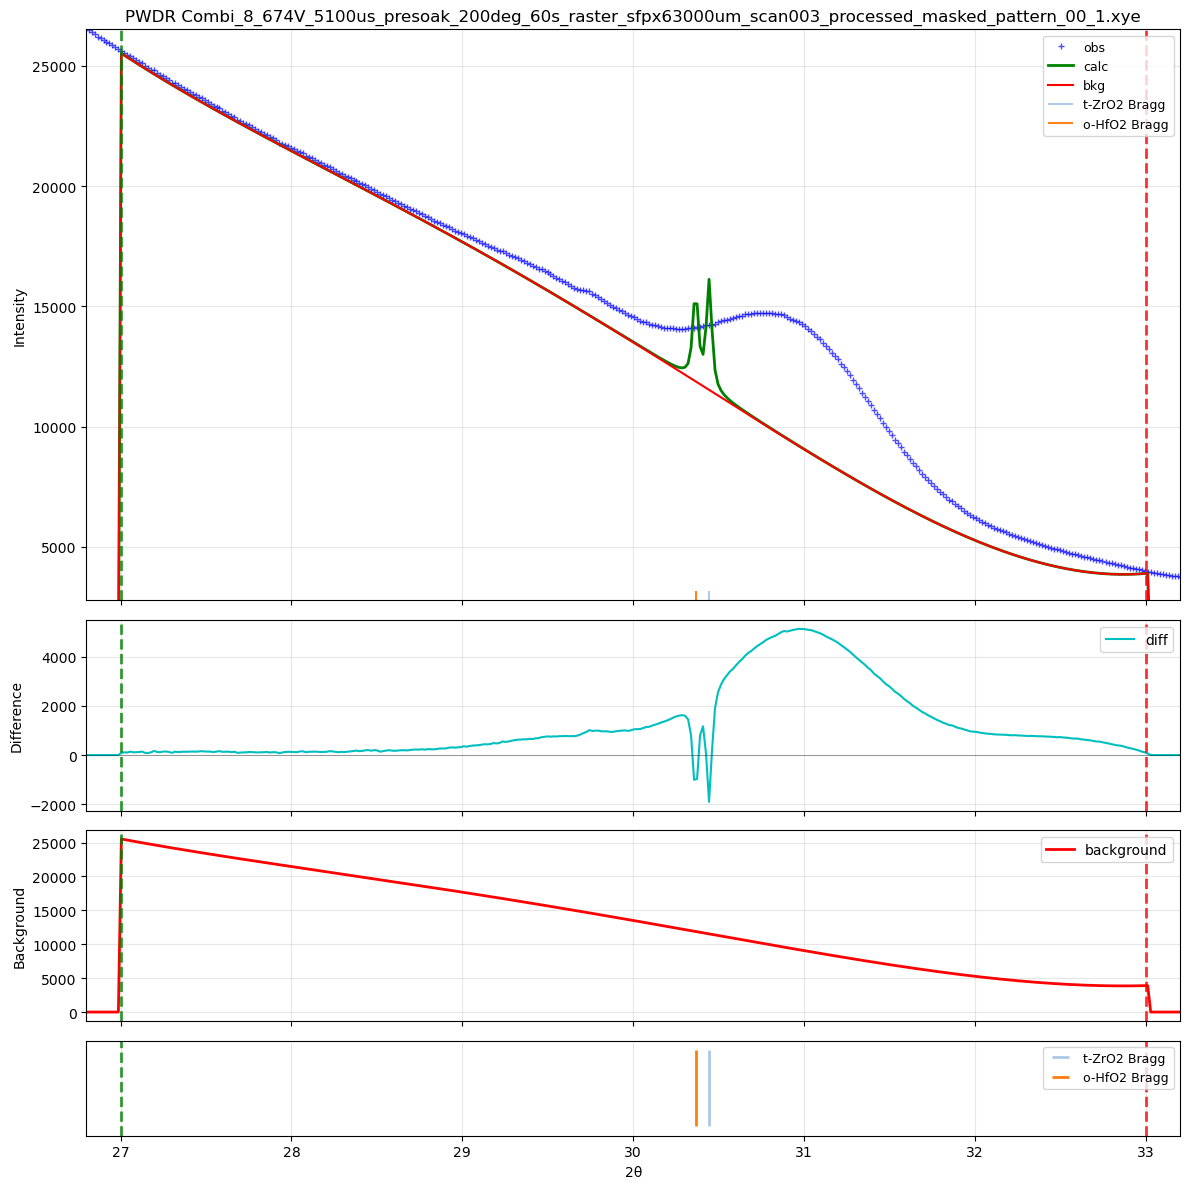

(<Figure size 1200x1200 with 4 Axes>,
 array([<Axes: title={'center': 'PWDR Combi_8_674V_5100us_presoak_200deg_60s_raster_sfpx63000um_scan003_processed_masked_pattern_00_1.xye'}, ylabel='Intensity'>,
        <Axes: ylabel='Difference'>, <Axes: ylabel='Background'>,
        <Axes: xlabel='2θ'>], dtype=object))

In [269]:
""" set refinement parameters --> Not all parameters can be changed this way 
If there are some parameters that you can't change, look up on hist.getHistEntryList()
and change the parameter with hist.setHistEntryValue(['Sample Parameters', 'Type'], 'Bragg-Brentano') """

### This is for changing Diffractometer type to Bragg-Brentano
## Type of sample parameters needs to change with setHistEntryValue
# hist.setHistEntryValue(['Sample Parameters', 'Type'], 'Bragg-Brentano')

# ## Define sample parameters for Bragg-Brentano even if it's not refined
# sample_params = hist.data['Sample Parameters']

# if 'Shift' not in sample_params:
#     sample_params['Shift'] = [0.0, False]  # [value, refine_flag]

# if 'Transparency' not in sample_params:
#     sample_params['Transparency'] = [0.0, False]

# if 'SurfRoughA' not in sample_params:
#     sample_params['SurfRoughA'] = [0.0, False]

# if 'SurfRoughB' not in sample_params:
#     sample_params['SurfRoughB'] = [0.0, False]

# print("Added missing Bragg-Brentano parameters")

# gpx.save()

## Need to load the file again before running refinement 
gpx = G2sc.G2Project("practice.gpx")
hist = gpx.histogram(0)

# # 이제 refinement 실행
refdict = {
    'histograms': [hist]
}
gpx.do_refinements([refdict])
gpx.save()

# plot_refinement_result_subplots(gpx, hist_index=0, phase_name="o_HfO2_1")
plot_refinement_result_subplots(gpx, hist_index=0)
## project level refinement 
# pardict = {'set': { 'Limits': [21, 24],
#                    'Sample Parameters': ['Absorption', 'Contrast', 'DisplaceX'],
#                    'Background': {'type': 'chebyschev-1', 'refine': True,
#                                   'peaks':[[0,True],[1,1,1]] }},
#           'clear': {'Instrument Parameters': ['U', 'V', 'W']}}

# gpx.do_refinements([pardict])

In [ ]:
"""
Extracting phase peaks #1
"""


import copy
import numpy as np
import matplotlib.pyplot as plt

def plot_phase_components_toggle_normalized(gpx, hist_index=0):
    """
    Extract phase-resolved contributions by toggling phases on/off (0-cycle recalc),
    then normalize them so that the sum of phase curves matches (ycalc - background).

    This keeps GSAS-II's full physics (instrument profile, microstrain/size,
    preferred orientation, absorption, scale factors, etc.) because we always
    read GSAS-II's own ycalc after each toggle.
    """

    # ---------- helpers ----------
    def _read_curves(hist):
        """Return axis and main curves from the histogram."""
        x      = np.asarray(hist.getdata('x'))
        y_obs  = np.asarray(hist.getdata('yobs'))
        y_calc = np.asarray(hist.getdata('ycalc'))
        y_bkg  = np.asarray(hist.getdata('background'))
        lims   = hist.data['Limits'][1]
        return x, y_obs, y_calc, y_bkg, lims

    def _phases_linked_to_hist(gpx, hist):
        """List phases actually linked to this histogram (by Reflection Lists)."""
        rl = hist.data.get('Reflection Lists', {}) or {}
        # Filter out non-phase keys
        return [k for k in rl.keys() if isinstance(k, str) and k not in ('data',)]

    def _get_HAP(gpx, hist, phase_name):
        """Return the HAP dict for a given phase/histogram, or None if missing."""
        ph = gpx.data.get('Phases', {}).get(phase_name)
        if not isinstance(ph, dict):
            return None
        return ph.get('Histograms', {}).get(hist.name)

    # ---------- prepare ----------
    hist = gpx.histogram(hist_index)
    x, y_obs, y_calc0, y_bkg0, lims = _read_curves(hist)
    hname = hist.name

    phases = _phases_linked_to_hist(gpx, hist)
    if not phases:
        raise RuntimeError("No phases linked to this histogram.")

    # Collect HAP entries and back up their 'Use' flags (and Scale if present)
    HAP = {}
    use_backup = {}
    for pn in phases:
        hap = _get_HAP(gpx, hist, pn)
        if hap is None:
            raise RuntimeError(f"HAP not found for phase '{pn}' in histogram '{hname}'.")
        HAP[pn] = hap
        use_backup[pn] = bool(hap.get('Use', True))

    # Ensure a baseline calculation with all phases enabled (0-cycle recalc)
    for hap in HAP.values():
        hap['Use'] = True
    gpx.data['Controls']['data']['max cyc'] = 0
    gpx.do_refinements([])

    # Reference total and background after recalc
    _, _, y_calc_full, y_bkg_full, _ = _read_curves(hist)
    target = y_calc_full - y_bkg_full

    # ---------- isolate each phase by toggling ----------
    part_curves = {}  # phase_name -> (ycalc - background) with only this phase enabled
    for keep in phases:
        # Disable all phases
        for hap in HAP.values():
            hap['Use'] = False
        # Enable only the target phase
        HAP[keep]['Use'] = True

        # 0-cycle recalc to get ycalc for this single phase
        gpx.data['Controls']['data']['max cyc'] = 0
        gpx.do_refinements([])

        # Phase-only contribution (background removed)
        _, _, y_calc_i, y_bkg_i, _ = _read_curves(hist)
        part_curves[keep] = y_calc_i - y_bkg_i

    # ---------- restore original HAP 'Use' flags and recalc full ----------
    for pn, hap in HAP.items():
        hap['Use'] = use_backup[pn]
    gpx.data['Controls']['data']['max cyc'] = 0
    gpx.do_refinements([])

    # ---------- normalize components to match target ----------
    # Stack phase curves into a design matrix A (npts x nphases)
    A = np.vstack([part_curves[pn] for pn in phases]).T  # columns = phases
    b = target

    # Solve least squares A c ≈ b; then clip to nonnegative for physicality
    # Note: If you want strict NNLS, replace with scipy.optimize.nnls (if available).
    c, *_ = np.linalg.lstsq(A, b, rcond=None)
    c = np.clip(c, 0.0, None)

    # Build normalized phase curves and their sum
    norm_curves = {}
    for pn, ci in zip(phases, c):
        norm_curves[pn] = part_curves[pn] * ci
    y_sum = np.sum(np.vstack([norm_curves[pn] for pn in phases]), axis=0)

    # Quality metric
    rel_err = float(np.linalg.norm(y_sum - b) / max(1.0, np.linalg.norm(b)))

    # ---------- plotting ----------
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True,
                                   gridspec_kw={'height_ratios': [2.2, 1.2]})

    # Top: observed / total calc / background
    ax1.plot(x, y_obs, 'k+', ms=3, alpha=0.6, label='Observed')
    ax1.plot(x, y_calc0, 'g-', lw=2, alpha=0.95, label='Calculated (total)')
    ax1.plot(x, y_bkg0, 'r--', lw=1.2, alpha=0.9, label='Background')
    ax1.set_ylabel('Intensity (a.u.)')
    ax1.legend(loc='upper right', ncol=3)
    ax1.grid(alpha=0.3)

    # Bottom: phase-only (background removed), normalized
    for pn in phases:
        ax2.plot(x, norm_curves[pn], lw=1.8, label=f'{pn} (normalized, no bkg)')
    ax2.plot(x, y_sum, '--', lw=1.4, alpha=0.9, label='Sum of phases (no bkg)')
    ax2.plot(x, b,   ':',  lw=1.4, alpha=0.9, label='Calc total − background')

    ax2.set_xlim(lims[0]-0.2, lims[1]+0.2)
    ax2.set_xlabel('2θ (deg)')
    ax2.set_ylabel('Phase intensity (no bkg)')
    ax2.legend(loc='upper right', ncol=2)
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Report scaling coefficients for transparency
    coef_report = {pn: float(ci) for pn, ci in zip(phases, c)}
    print(f"[check] relative_error (sum vs total-bkg): {rel_err:.3g}")
    print("[scaling coefficients applied to phase-only curves]")
    for pn in phases:
        print(f"  {pn:>12s}: {coef_report[pn]:.6g}")

    return {
        "x": x,
        "phases": phases,
        "phase_curves_raw": part_curves,     # before normalization
        "phase_curves_norm": norm_curves,    # after normalization
        "coefficients": coef_report,
        "relative_error": rel_err
    }


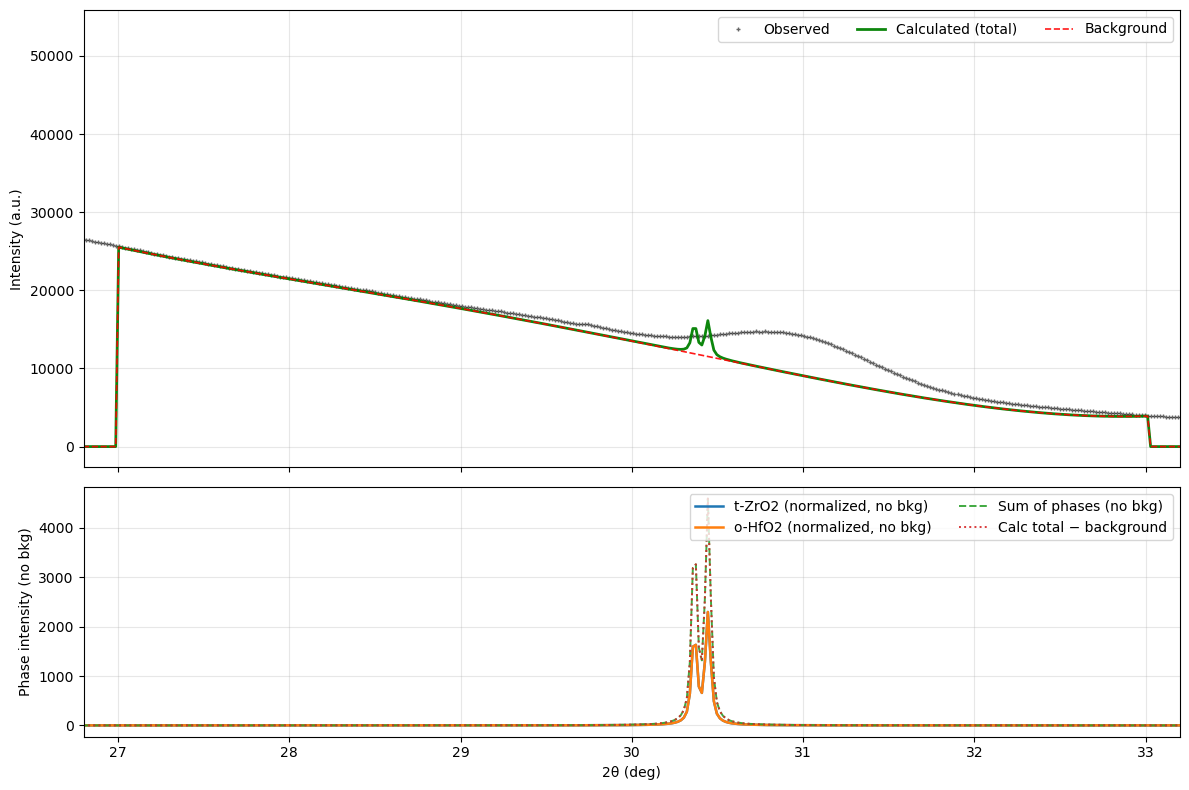

[check] relative_error (sum vs total-bkg): 5.67e-16
[scaling coefficients applied to phase-only curves]
        t-ZrO2: 0.5
        o-HfO2: 0.5


In [336]:
# After your refinement is up to date
gpx.data['Controls']['data']['max cyc'] = 0
gpx.do_refinements([])

res = plot_phase_components_toggle_normalized(gpx, hist_index=0)


In [339]:
"""
Extracting phase peaks #2
"""

import numpy as np
import matplotlib.pyplot as plt

# ---------- TCH pseudo-Voigt profile (area-normalized) ----------
def _tch_profile(x, x0, sig2, gam):
    """
    Thompson–Cox–Hastings pseudo-Voigt on 2θ grid.
    Inputs:
      x: 2θ array
      x0: peak position (2θ)
      sig2: Gaussian variance parameter (GSAS-II Reflection List 'sig^2')
      gam: Lorentz FWHM parameter (GSAS-II Reflection List 'gam')
    Returns:
      area-normalized profile values at x
    """
    # Gaussian FWHM from variance, Lorentz FWHM directly from gam
    HG = np.sqrt(8.0*np.log(2.0) * max(sig2, 0.0))   # Gaussian FWHM
    HL = 2.0*max(gam, 0.0)                            # Lorentz FWHM

    # TCH mixing using the 5th-root formula for composite FWHM H
    # and the empirical eta polynomial in y = HL/H
    H = (HG**5 + 2.69269*HG**4*HL + 2.42843*HG**3*HL**2
         + 4.47163*HG**2*HL**3 + 0.07842*HG*HL**4 + HL**5)**(1.0/5.0)
    if H <= 0:
        return np.zeros_like(x)

    y = HL / H
    eta = max(0.0, min(1.0, 1.36603*y - 0.47719*y*y + 0.11116*y*y*y))

    # Convert FWHM to distribution parameters
    sigma = H / (2.0*np.sqrt(2.0*np.log(2.0)))   # Gaussian sigma
    gammaL = H / 2.0                              # Lorentz half-width

    dx = x - x0
    # Area-normalized Gaussian and Lorentz
    G = np.exp(-0.5*(dx/sigma)**2) / (sigma*np.sqrt(2.0*np.pi)) if sigma > 0 else np.zeros_like(x)
    L = (gammaL/np.pi) / (dx*dx + gammaL*gammaL) if gammaL > 0 else np.zeros_like(x)

    return (1.0 - eta)*G + eta*L


# ---------- small helpers ----------
def _get_hist(gpx, hist_index):
    hist = gpx.histogram(hist_index)
    x      = hist.getdata('x')
    y_obs  = hist.getdata('yobs')
    y_calc = hist.getdata('ycalc')
    y_bkg  = hist.getdata('background')
    lims   = hist.data['Limits'][1]
    # apply plot limits
    mask = (x >= lims[0]) & (x <= lims[1])
    return hist, x[mask], y_obs[mask], y_calc[mask], y_bkg[mask], lims, mask

def _hap_scale(gpx, hist, phase_name):
    """HAP 'Scale' lives in phase->Histograms[hist.name]['Scale'] as [value, varyFlag]"""
    hap = gpx.data['Phases'][phase_name]['Histograms'][hist.name]
    val = hap.get('Scale', 1.0)
    return float(val[0] if isinstance(val, (list, tuple)) else val)

def _sample_scale(hist):
    """Sample Parameters 'Scale' is [value, varyFlag]"""
    scl = hist.data['Sample Parameters'].get('Scale', 1.0)
    return float(scl[0] if isinstance(scl, (list, tuple)) else scl)


# ---------- read reflections + Pawley intensities and build phase curve ----------
def _phase_curve_from_reflection_list(gpx, hist, x_full, mask, phase_name):
    """
    Build a phase-resolved curve using Reflection List and Pawley intensities.
    Reflection columns (per your screenshot):
    H K L mul d pos sig^2 gam Fo^2 Fc^2 phase Icorr Prfo Trans ExtP Ilor μstrain Size
                         3   4  5   6    7      8    9    10   11    12   13    14   15   16      17
    We will use: pos(5), sig^2(6), gam(7), mul(3), Icorr(11), Trans(13), ExtP(14)
    """
    refl = hist.data['Reflection Lists'][phase_name]['RefList']
    if refl.size == 0:
        return x_full[mask], np.zeros(mask.sum())

    # columns by index
    pos  = np.asarray(refl[:,5], dtype=float)
    sig2 = np.asarray(refl[:,6], dtype=float)
    gam  = np.asarray(refl[:,7], dtype=float)
    mul  = np.asarray(refl[:,3], dtype=float)
    Icorr = np.asarray(refl[:,11], dtype=float)
    Trans = np.asarray(refl[:,13], dtype=float)
    ExtP  = np.asarray(refl[:,14], dtype=float)

    # Pawley intensities are stored in the phase under 'Pawley ref'
    # Format per item: [h,k,l,m, d, True, intensity, sigmaI]
    paw_items = gpx.data['Phases'][phase_name]['Pawley ref']
    I_paw = np.array([float(item[6]) for item in paw_items], dtype=float)

    # very important: guard against any mismatch in counts
    n = min(len(pos), len(I_paw))
    pos, sig2, gam = pos[:n], sig2[:n], gam[:n]
    mul, Icorr, Trans, ExtP = mul[:n], Icorr[:n], Trans[:n], ExtP[:n]
    I_paw = I_paw[:n]

    # effective reflection intensity (Pawley × corrections)
    I_eff = I_paw * mul * Icorr * Trans * ExtP

    # grid and curve
    x = x_full[mask]
    y_phase = np.zeros_like(x, dtype=float)
    for x0, s2, gL, I in zip(pos, sig2, gam, I_eff):
        if I == 0.0:
            continue
        prof = _tch_profile(x, x0, s2, gL)  # area-normalized
        y_phase += I * prof

    # apply sample and HAP scales to match absolute scale in 'ycalc'
    s_scale = _sample_scale(hist) * _hap_scale(gpx, hist, phase_name)
    y_phase *= s_scale
    return x, y_phase


# ---------- main plotting routine ----------
def plot_phase_components_pawley(gpx, hist_index=0, phases=None):
    """
    Reconstruct phase-resolved curves from Reflection List + Pawley intensities.
    Plots:
      - top: y_obs, y_calc, background
      - bottom: per-phase curves (absolute, no background), their sum, and (calc - background)
    Returns a small dict with mismatch metric for quick sanity check.
    """
    hist, x, y_obs, y_calc, y_bkg, lims, mask = _get_hist(gpx, hist_index)
    if phases is None:
        phases = list(hist.data['Reflection Lists'].keys())

    # per-phase curves on the same grid
    phase_curves = {}
    for pn in phases:
        xi, yi = _phase_curve_from_reflection_list(gpx, hist, hist.getdata('x'), mask, pn)
        phase_curves[pn] = yi

    # checks
    y_sum = np.sum(np.vstack([phase_curves[p] for p in phases]), axis=0)
    target = y_calc - y_bkg

    # relative L2 mismatch in the plotted window
    denom = max(1e-12, np.linalg.norm(target))
    rel_err = float(np.linalg.norm(y_sum - target) / denom) * 100.0

    # ---------- plotting ----------
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 1, height_ratios=[3, 2], hspace=0.08)

    # top panel
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(x, y_obs, "+", ms=2.5, alpha=0.6, label="Observed")
    ax1.plot(x, y_calc, lw=1.6, label="Calculated (total)")
    ax1.plot(x, y_bkg, lw=1.2, ls="--", label="Background")
    ax1.set_xlim(lims[0], lims[1])
    ax1.set_ylabel("Intensity (a.u.)")
    ax1.legend(loc="upper right")
    ax1.grid(alpha=0.25)

    # bottom panel
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    for pn, yi in phase_curves.items():
        ax2.plot(x, yi, lw=1.6, label=f"{pn} (no bkg)")
    ax2.plot(x, y_sum, lw=1.2, ls="--", label="Sum of phases (no bkg)")
    ax2.plot(x, target, lw=1.2, ls=":", label="Calc total − background")
    ax2.set_xlabel(r"2$\theta$ (deg)")
    ax2.set_ylabel("Phase intensity (no bkg)")
    ax2.legend(loc="upper right", ncol=2)
    ax2.grid(alpha=0.25)

    plt.show()

    return {
        "relative_error_percent": rel_err,
        "phases": phases,
        "sample_scale": _sample_scale(hist),
        "hap_scales": {pn: _hap_scale(gpx, hist, pn) for pn in phases},
    }


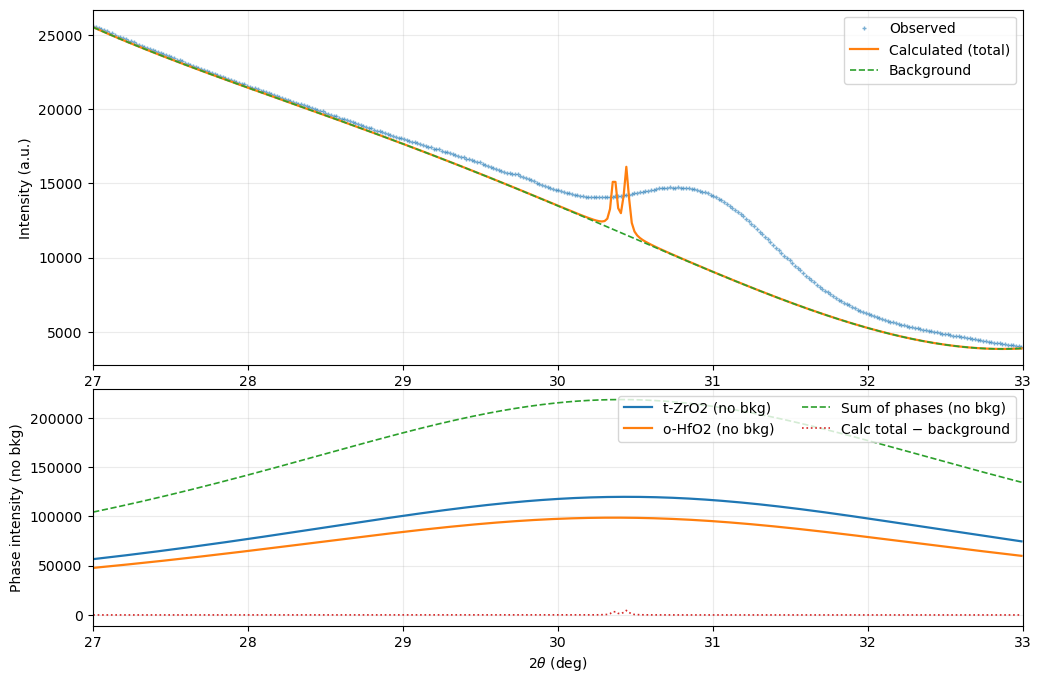

{'relative_error_percent': 41821.448824232575, 'phases': ['t-ZrO2', 'o-HfO2'], 'sample_scale': 6.119959616975667, 'hap_scales': {'t-ZrO2': 1.0, 'o-HfO2': 1.0}}


In [340]:
result = plot_phase_components_pawley(gpx, hist_index=0)
print(result)